# Ejecuta un cálculo de fuente fija con un paralelepípedo de agua 2

## Objectivo

El objetivo de este trabajo es crear un cubo de agua con una fuente monoenergética con una distribución espacial coseno y realizar un estudio de "fixed souce". Nos interesaremos por el flujo y la corriente a la salida. También aprovecharemos este trabajo para observar la diferencia si tenemos en cuenta la "Thermal Scattering Law" (S(alfa,beta)).

## Ayuda

Importar las bibliotecas necesarias para el código.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import openmc
import os

In [3]:
openmc_data = "/Users/gregoire_lebreton/anaconda3/envs/internship/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

## Materiales

Definición de materiales (agua) una sin tener en cuenta la "Thermal Scattering Law" y la otra teniendo en cuenta la "Thermal Scattering Law".

In [4]:
mat01=openmc.Material(material_id=1) #mat sin S(alpha,beta)
mat01.add_nuclide("H1",2)
mat01.add_nuclide("O16",1)
mat01.set_density('g/cm3', 1)

mat02=openmc.Material(material_id=2) #mat con S(alpha,beta)
mat02.add_nuclide("H1",2)
mat02.add_nuclide("O16",1)
mat02.add_s_alpha_beta('c_H_in_H2O')
mat02.set_density('g/cm3', 1)

## Graficars cross section 

Vamos a trazar la sección transversal efectiva miscroscópica de la scattering, la absorción y la total en función de la energía y observar las diferencias cuando se tiene en cuenta o no la "Thermal Scattering Law". 

Text(0.5, 1.0, 'XS total con S(alpha,beta)')

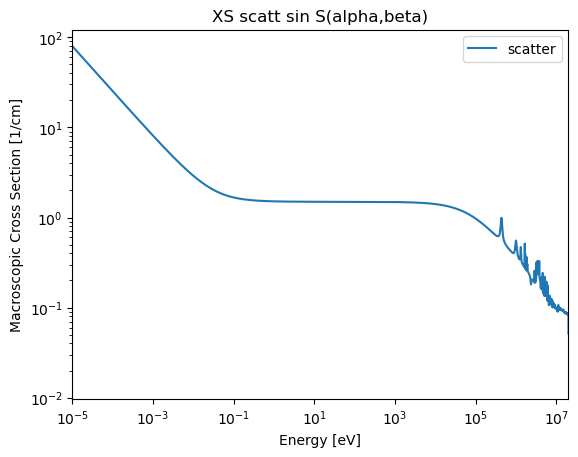

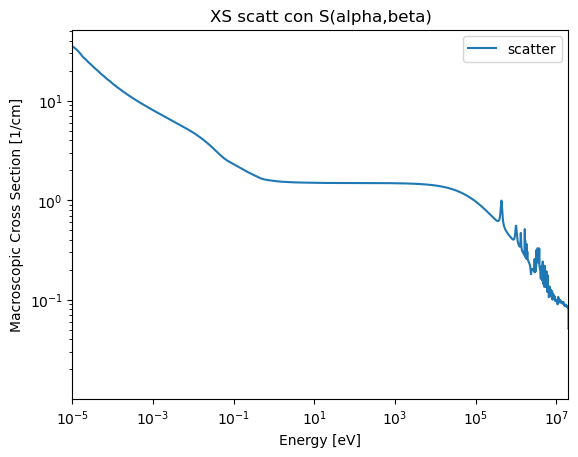

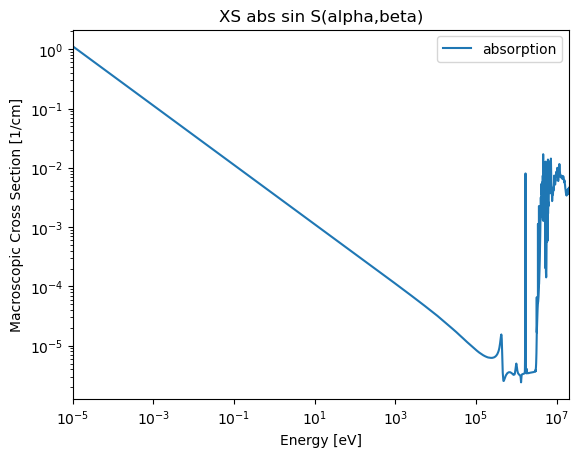

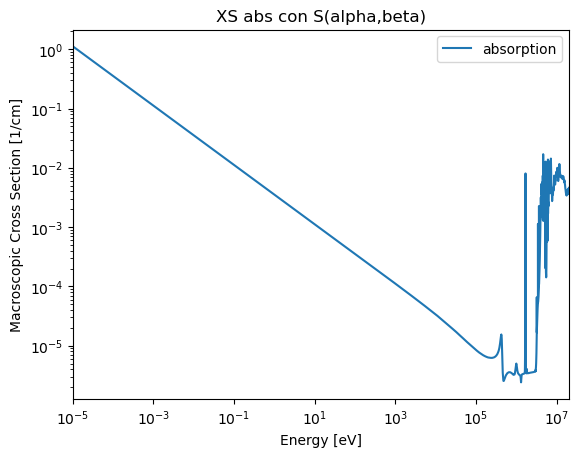

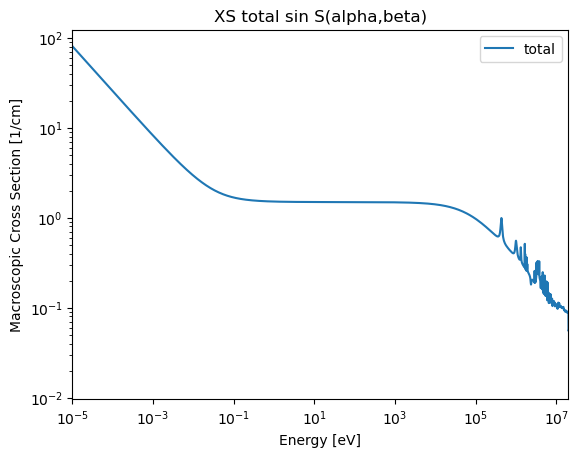

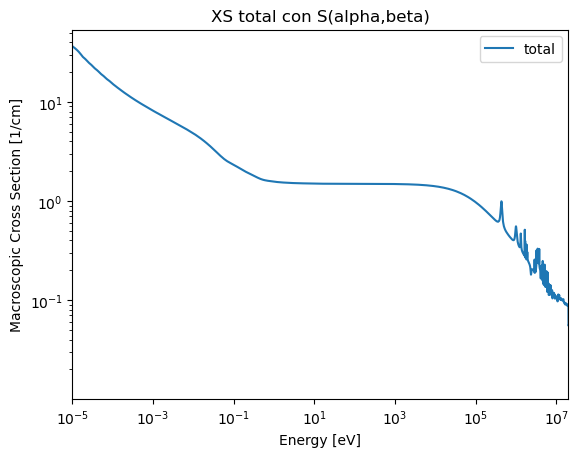

In [5]:
openmc.plot_xs(mat01,['scatter'])
plt.title('XS scatt sin S(alpha,beta)')

openmc.plot_xs(mat02,['scatter'])
plt.title('XS scatt con S(alpha,beta)')

openmc.plot_xs(mat01,['absorption'])
plt.title('XS abs sin S(alpha,beta)')

openmc.plot_xs(mat02,['absorption'])
plt.title('XS abs con S(alpha,beta)')

openmc.plot_xs(mat01,['total'])
plt.title('XS total sin S(alpha,beta)')

openmc.plot_xs(mat02,['total'])
plt.title('XS total con S(alpha,beta)')

## Geometría

Definición de geometría. Para este código utilizamos un cubo de 10 cm lleno de agua y con vacío en el exterior. 

In [6]:
Lx,Ly,Lz=10.0,10.0,10.0

surf01=openmc.XPlane(boundary_type = "vacuum", surface_id = 1)
surf02=openmc.YPlane(boundary_type = "vacuum", surface_id = 2)
surf03=openmc.ZPlane(boundary_type = "vacuum", surface_id = 3) 
surf04=openmc.XPlane(Lx,boundary_type = "vacuum", surface_id = 4)
surf05=openmc.YPlane(Ly,boundary_type = "vacuum", surface_id = 5)
surf06=openmc.ZPlane(Lz,boundary_type = "vacuum", surface_id = 6)

cell01=openmc.Cell(region = +surf01 & -surf04 & +surf02 & -surf05 & +surf03 & -surf06, fill=mat01 , cell_id = 1 ) #cell sin S(alpha,beta)
cell02=openmc.Cell(region = +surf01 & -surf04 & +surf02 & -surf05 & +surf03 & -surf06, fill=mat02 , cell_id = 2 ) #cell con S(alpha,beta)

univ01=openmc.Universe(cells = [cell01], universe_id = 1) #univ sin S(alpha,beta)
univ02=openmc.Universe(cells = [cell02], universe_id = 2) #univ con S(alpha,beta)

#univ01.plot(width = (Lx, Ly))
#univ02.plot(width = (Lx, Ly))

## Parámetros

Definición de los parámetros. Aquí vamos a generar una simulación con 1e8 partículas 1 batches y todos con el modo de funcionamiento "fixed source".

In [7]:
sets = openmc.Settings()
sets.run_mode = "fixed source"
sets.particles = 100000000
sets.batches = 1
sets.inactive = 10
sets.photon_transport = True

## Fuente 

Definición de la fuente monoenergética en la superficie (z=0) y con una distribución espacial coseno.

In [8]:
#mono-energia
E_f=1.0e6

In [9]:
X=np.linspace(0,Lx,100)
Y=np.linspace(0,Ly,100)
PX=np.sin(np.pi*X/(Lx))
PY=np.sin(np.pi*Y/Lx)
Z=[1e-6,]
PZ=[1.0,]
print(Z)

source=openmc.Source()
source.space = openmc.stats.CartesianIndependent(openmc.stats.Tabular(X,PX),openmc.stats.Tabular(Y,PY),openmc.stats.Discrete(Z,PZ)) #cos distribucion 

source.energy = openmc.stats.Discrete([E_f], [1.0]) #mono-energia
sets.source=source

[1e-06]


## Tallies

Definición de las distintas grillas, filtros y tallies útiles.

In [10]:
tallies = openmc.Tallies()

# Grilla
mesh_xy = openmc.RegularMesh(mesh_id = 1)
mesh_xy.lower_left = [0, 0, 0]
mesh_xy.upper_right = [Lx, Ly, Lz]
mesh_xy.dimension = [100, 100, 1]

mesh_xz = openmc.RegularMesh(mesh_id = 2)
mesh_xz.lower_left = [0, 0, 0]
mesh_xz.upper_right = [Lx, Ly, Lz]
mesh_xz.dimension = [100, 1, 100]

mesh_x = openmc.RegularMesh(mesh_id = 3)
mesh_x.lower_left = [0, 0, 0]
mesh_x.upper_right = [Lx, Ly, Lz]
mesh_x.dimension = [100, 1, 1]

mesh_z = openmc.RegularMesh(mesh_id = 4)
mesh_z.lower_left = [0, 0, 0]
mesh_z.upper_right = [Lx, Ly, Lz]
mesh_z.dimension = [1, 1, 100]

# Filtro de grilla
filter_mesh_xy = openmc.filter.MeshFilter(mesh_xy, filter_id = 1)
filter_mesh_xz = openmc.filter.MeshFilter(mesh_xz, filter_id = 2)
filter_mesh_x = openmc.filter.MeshFilter(mesh_x, filter_id = 3)
filter_mesh_z = openmc.filter.MeshFilter(mesh_z, filter_id = 4)

# Filtro de particulas
filter_neutron = openmc.ParticleFilter(['neutron'], filter_id = 5)
filter_photon = openmc.ParticleFilter(['photon'], filter_id = 6)

#Filtro de energías
filter_energy_neutron = openmc.filter.EnergyFilter(np.logspace(np.log10(1e-5), np.log10(2e7), 201),filter_id = 7)
filter_energy_photon = openmc.filter.EnergyFilter(np.linspace(0, 2e7, 201), filter_id = 8)

# Tallies
flux_neutron_xy = openmc.Tally(name = 'flux_neutron_xy', tally_id = 1)
flux_neutron_xy.scores = ["flux"]
flux_neutron_xy.filters = [filter_mesh_xy, filter_neutron]
tallies.append(flux_neutron_xy)

flux_photon_xy = openmc.Tally(name = 'flux_photon_xy',tally_id = 2)
flux_photon_xy.scores = ["flux"]
flux_photon_xy.filters = [filter_mesh_xy, filter_photon]
tallies.append(flux_photon_xy)

flux_neutron_xz = openmc.Tally(name = 'flux_neutron_xz', tally_id = 3)
flux_neutron_xz.scores = ["flux"]
flux_neutron_xz.filters = [filter_mesh_xz, filter_neutron]
tallies.append(flux_neutron_xz)

flux_photon_xz = openmc.Tally(name = 'flux_photon_xz',tally_id = 4)
flux_photon_xz.scores = ["flux"]
flux_photon_xz.filters = [filter_mesh_xz, filter_photon]
tallies.append(flux_photon_xz)

flux_neutron_x = openmc.Tally(name = 'flux_neutron_x', tally_id = 5)
flux_neutron_x.scores = ["flux"]
flux_neutron_x.filters = [filter_mesh_x, filter_neutron]
tallies.append(flux_neutron_x)

flux_neutron_z = openmc.Tally(name = 'flux_neutron_z', tally_id = 6)
flux_neutron_z.scores = ["flux"]
flux_neutron_z.filters = [filter_mesh_z, filter_neutron]
tallies.append(flux_neutron_z)

flux_photon_x = openmc.Tally(name = 'flux_photon_x',tally_id = 7)
flux_photon_x.scores = ["flux"]
flux_photon_x.filters = [filter_mesh_x, filter_photon]
tallies.append(flux_photon_x)

flux_photon_z = openmc.Tally(name = 'flux_photon_z',tally_id = 8)
flux_photon_z.scores = ["flux"]
flux_photon_z.filters = [filter_mesh_z, filter_photon]
tallies.append(flux_photon_z)

spectra_neutron = openmc.Tally(name = 'spectra_neutron', tally_id = 9)
spectra_neutron.scores = ['flux']
spectra_neutron.filters = [filter_energy_neutron, filter_neutron]
tallies.append(spectra_neutron)

spectra_photon = openmc.Tally(name='spectra_photon',tally_id = 10)
spectra_photon.scores = ['flux']
spectra_photon.filters = [filter_energy_photon, filter_photon]
tallies.append(spectra_photon)

leak_salida = openmc.Tally(name='leakage_salida')
leak_salida.filters = [openmc.SurfaceFilter(surf06)]
leak_salida.scores = ['current']
tallies.append(leak_salida)

leak_entrada= openmc.Tally(name='leakage_entrada')
leak_entrada.filters = [openmc.SurfaceFilter(surf03)]
leak_entrada.scores = ['current']
tallies.append(leak_entrada)

leak_2= openmc.Tally(name='leakage_2')
leak_2.filters = [openmc.SurfaceFilter(surf02)]
leak_2.scores = ['current']
tallies.append(leak_2)

leak_3= openmc.Tally(name='leakage_3')
leak_3.filters = [openmc.SurfaceFilter(surf04)]
leak_3.scores = ['current']
tallies.append(leak_3)

leak_4= openmc.Tally(name='leakage_4')
leak_4.filters = [openmc.SurfaceFilter(surf05)]
leak_4.scores = ['current']
tallies.append(leak_4)

leak_5= openmc.Tally(name='leakage_5')
leak_5.filters = [openmc.SurfaceFilter(surf01)]
leak_5.scores = ['current']
tallies.append(leak_5)

## Generación de los archivos `.xml` sin S

In [11]:
geom01 = openmc.Geometry(univ01)
geom01.export_to_xml()

mats01 = openmc.Materials(geom01.get_all_materials().values()) 
mats01.cross_sections = openmc_data
mats01.export_to_xml()

sets.export_to_xml()

tallies.export_to_xml()

In [12]:
!rm statepoint.110.h5
!rm summary.h5
openmc.run()

rm: statepoint.110.h5: No such file or directory


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

In [13]:
sp_1=openmc.StatePoint('statepoint.110.1.h5')
S0=1.0

## Generación de los archivos `.xml` con S

In [14]:
geom02 = openmc.Geometry(univ02)
geom02.export_to_xml()

mats02 = openmc.Materials(geom02.get_all_materials().values()) 
mats02.cross_sections = openmc_data
mats02.export_to_xml()

sets.export_to_xml()

tallies.export_to_xml()

In [ ]:
!rm statepoint.110.h5
!rm summary.h5
openmc.run()

rm: statepoint.110.h5: No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%

In [15]:
sp_2=openmc.StatePoint(filepath='statepoint.110.2.h5')
S0=1.0

## Procesamiento de tallies

### Mapas 2D

#### flujo XY sin S

(10000, 1, 1)
100 0.0 10.0 10.0
100 0.0 10.0 10.0
1 0.0 10.0 10.0
0.1 0.1 10.0


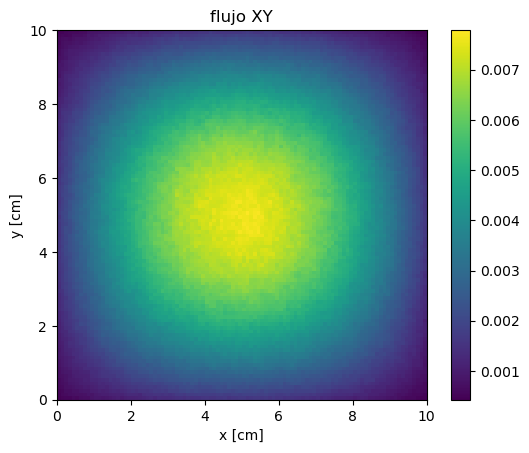

In [16]:
tally=sp_1.get_tally(name='flux_neutron_xy')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

print(data.mean.shape)

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx,Ny)
data.std_dev.shape=(Nx,Ny)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv = data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.imshow(data_mean, origin='lower', interpolation='none', extent=(xmin,xmax,ymin,ymax), cmap='viridis')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('flujo XY')
plt.show()


#### flujo XY con S 

100 0.0 10.0 10.0
100 0.0 10.0 10.0
1 0.0 10.0 10.0
0.1 0.1 10.0


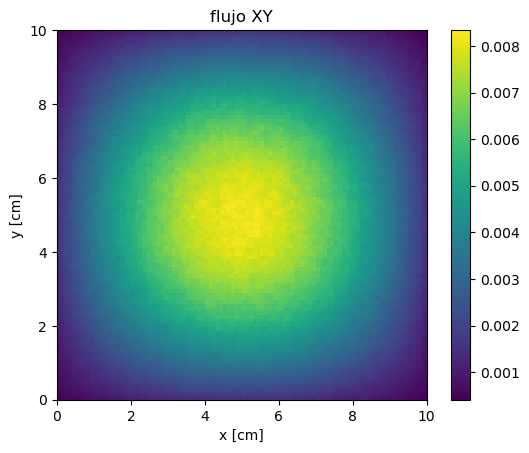

In [17]:
tally=sp_2.get_tally(name='flux_neutron_xy')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx,Ny)
data.std_dev.shape=(Nx,Ny)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv = data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.imshow(data_mean, origin='lower', interpolation='none', extent=(xmin,xmax,ymin,ymax), cmap='viridis')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('flujo XY')
plt.show()

#### flujo XZ sin S

100 0.0 10.0 10.0
1 0.0 10.0 10.0
100 0.0 10.0 10.0
0.1 10.0 0.1


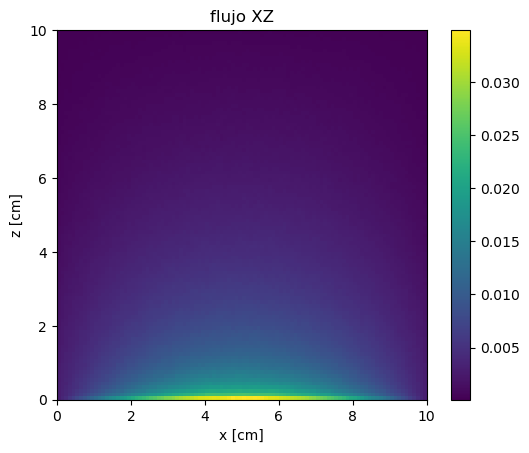

In [18]:
tally=sp_1.get_tally(name='flux_neutron_xz')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx,Nz)
data.std_dev.shape=(Nx,Nz)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv = data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.imshow(data_mean, origin='lower', interpolation='none', extent=(xmin,xmax,zmin,zmax), cmap='viridis')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.title('flujo XZ')
plt.show()

#### flujo XZ con S

100 0.0 10.0 10.0
1 0.0 10.0 10.0
100 0.0 10.0 10.0
0.1 10.0 0.1


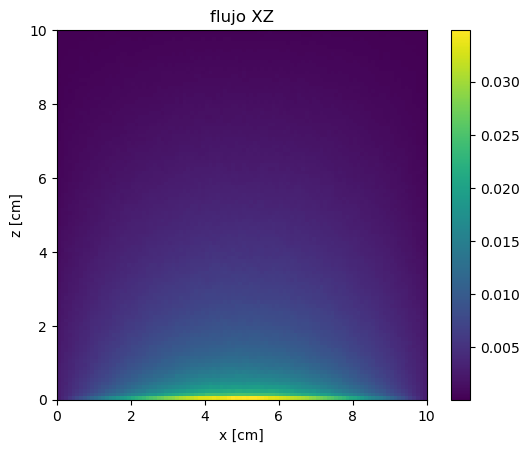

In [19]:
tally=sp_2.get_tally(name='flux_neutron_xz')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx,Nz)
data.std_dev.shape=(Nx,Nz)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv = data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.imshow(data_mean, origin='lower', interpolation='none', extent=(xmin,xmax,zmin,zmax), cmap='viridis')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('z [cm]')
plt.title('flujo XZ')
plt.show()

### Flujo integrado

#### flujo integrado X sin S

100 0.0 10.0 10.0
1 0.0 10.0 10.0
1 0.0 10.0 10.0
0.1 10.0 10.0


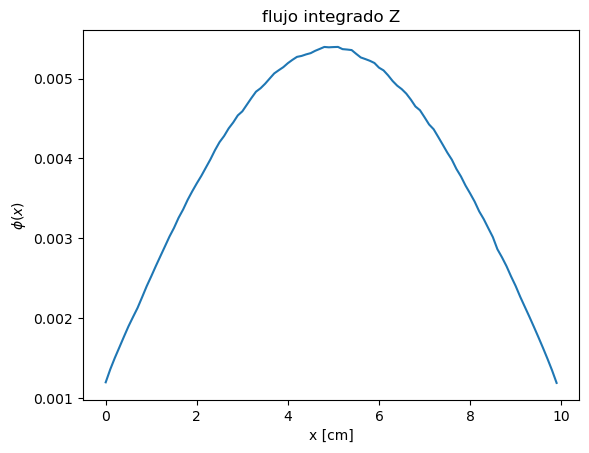

In [20]:
tally=sp_1.get_tally(name='flux_neutron_x')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx)
data.std_dev.shape=(Nx)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv= data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.plot(data_mean)
plt.xticks([0,20,40,60,80,100],[0,2,4,6,8,10])
plt.xlabel('x [cm]')
plt.ylabel('$\phi(x)$')
plt.title('flujo integrado Z')
plt.show()

#### flujo integrado X con S

100 0.0 10.0 10.0
1 0.0 10.0 10.0
1 0.0 10.0 10.0
0.1 10.0 10.0


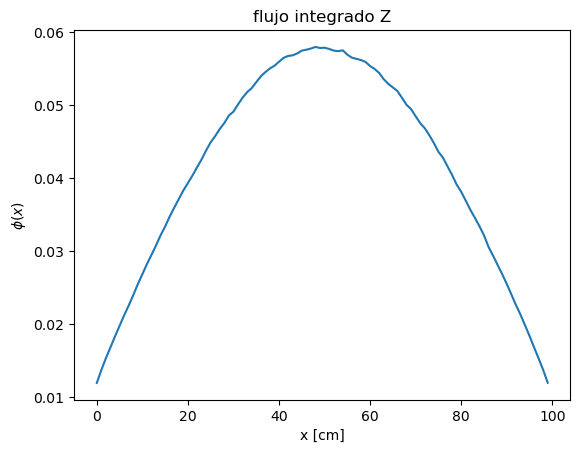

In [21]:
tally=sp_2.get_tally(name='flux_neutron_x')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx)
data.std_dev.shape=(Nx)

data_mean = data.mean*S0/(dx/Nx*dy/Ny)
data_stdv= data.std_dev*S0/(dx/Nx*dy/Ny)


print(dx/Nx, dy/Ny, dz/Nz)


plt.plot(data_mean)
plt.xlabel('x [cm]')
plt.ylabel('$\phi(x)$')
plt.title('flujo integrado Z')
plt.show()

#### flujo integrado Z sin S

1 0.0 10.0 10.0
1 0.0 10.0 10.0
100 0.0 10.0 10.0
10.0 10.0 0.1


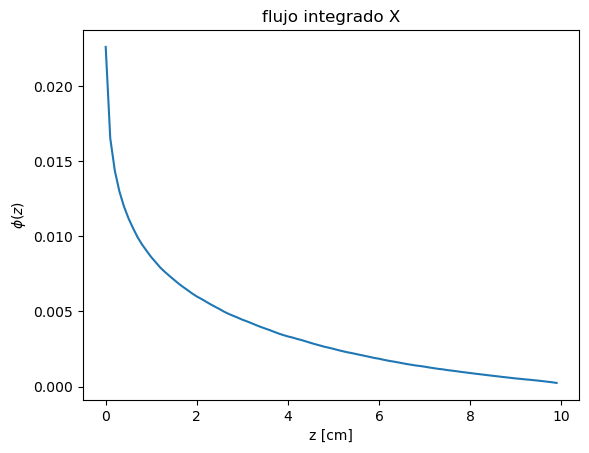

In [22]:
tally=sp_1.get_tally(name='flux_neutron_z')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nz)
data.std_dev.shape=(Nz)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv = data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.plot(data_mean)
plt.xticks([0,20,40,60,80,100],[0,2,4,6,8,10])
plt.xlabel('z [cm]')
plt.ylabel('$\phi(z)$')
plt.title('flujo integrado X')
plt.show()

#### flujo integrado Z con S

1 0.0 10.0 10.0
1 0.0 10.0 10.0
100 0.0 10.0 10.0
10.0 10.0 0.1


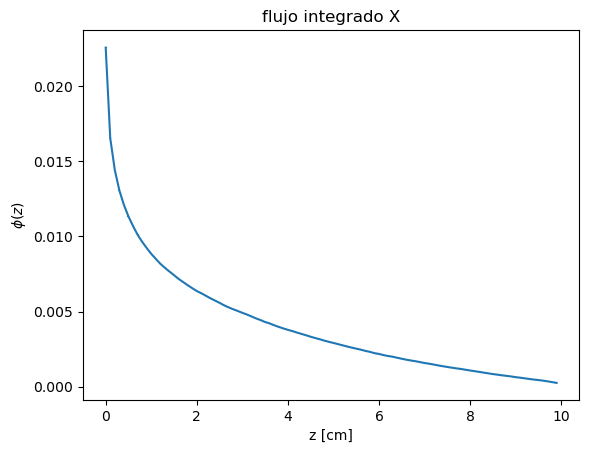

In [23]:
tally=sp_2.get_tally(name='flux_neutron_z')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['flux'])

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

print(Nx, xmin, xmax, dx)

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

print(Ny, ymin, ymax, dy)

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nz, zmin, zmax, dz)

data.mean.shape=(Nz)
data.std_dev.shape=(Nz)

data_mean = data.mean*S0/(dx/Nx*dy/Ny*dz/Nz)
data_stdv = data.std_dev*S0/(dx/Nx*dy/Ny*dz/Nz)


print(dx/Nx, dy/Ny, dz/Nz)


plt.errorbar(range(100),data_mean,yerr=data_stdv)
plt.xticks([0,20,40,60,80,100],[0,2,4,6,8,10])
plt.xlabel('z [cm]')
plt.ylabel('$\phi(z)$')
plt.title('flujo integrado X')
plt.show()

### Graphicar espectros

#### Espectro sin S

In [24]:
dV=Lx*Ly*Lz
data=sp_1.get_tally(name='spectra_neutron').get_pandas_dataframe(nuclides=False)
data.columns=['Emin','Emax','particle','score','mean','stdv']
print(data)
Emin=data['Emin'].values
Emax=data['Emax'].values
E=(Emin+Emax)/2.0
dE=Emax-Emin

data_mean=data['mean']*S0/(dE*dV)
data_stdv=data['stdv']*S0/(dE*dV)

        Emin     Emax particle score     mean     stdv
0   1.00e-05 1.15e-05  neutron  flux 2.60e-08 1.92e-08
1   1.15e-05 1.33e-05  neutron  flux 8.94e-09 8.94e-09
2   1.33e-05 1.53e-05  neutron  flux 6.56e-08 3.85e-08
3   1.53e-05 1.76e-05  neutron  flux 9.28e-09 6.73e-09
4   1.76e-05 2.03e-05  neutron  flux 0.00e+00 0.00e+00
..       ...      ...      ...   ...      ...      ...
195 9.85e+06 1.14e+07  neutron  flux 0.00e+00 0.00e+00
196 1.14e+07 1.31e+07  neutron  flux 0.00e+00 0.00e+00
197 1.31e+07 1.51e+07  neutron  flux 0.00e+00 0.00e+00
198 1.51e+07 1.74e+07  neutron  flux 0.00e+00 0.00e+00
199 1.74e+07 2.00e+07  neutron  flux 0.00e+00 0.00e+00

[200 rows x 6 columns]


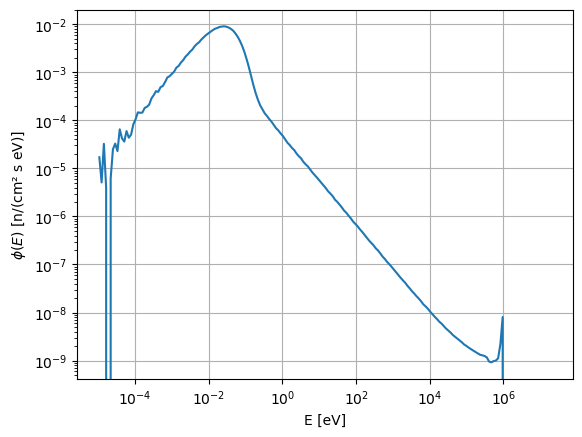

In [25]:
plt.loglog(E,data_mean)
plt.xlabel('E [eV]')
plt.ylabel('$\phi(E)$ [n/(cm² s eV)]')
plt.grid()
plt.show()


#### Espectro con S

In [26]:
dV=Lx*Ly*Lz
data=sp_2.get_tally(name='spectra_neutron').get_pandas_dataframe(nuclides=False)
data.columns=['Emin','Emax','particle','score','mean','stdv']
Emin=data['Emin'].values
Emax=data['Emax'].values
E=(Emin+Emax)/2.0
dE=Emax-Emin

data_meanS=data['mean']*S0/(dE*dV)
data_stdv=data['stdv']*S0/(dE*dV)

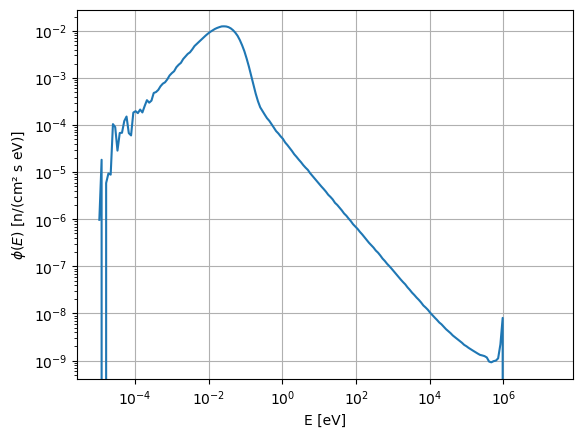

In [27]:
plt.loglog(E,data_meanS)
plt.xlabel('E [eV]')
plt.ylabel('$\phi(E)$ [n/(cm² s eV)]')
plt.grid()
plt.show()


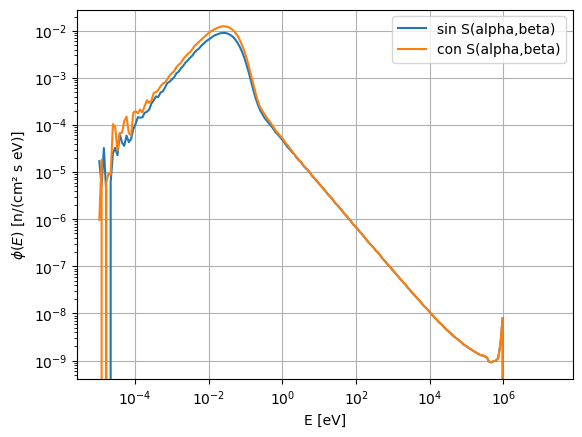

In [28]:
plt.loglog(E,data_mean, label="sin S(alpha,beta)")
plt.loglog(E,data_meanS, label="con S(alpha,beta)")
plt.xlabel('E [eV]')
plt.ylabel('$\phi(E)$ [n/(cm² s eV)]')
plt.legend()
plt.grid()
plt.show()

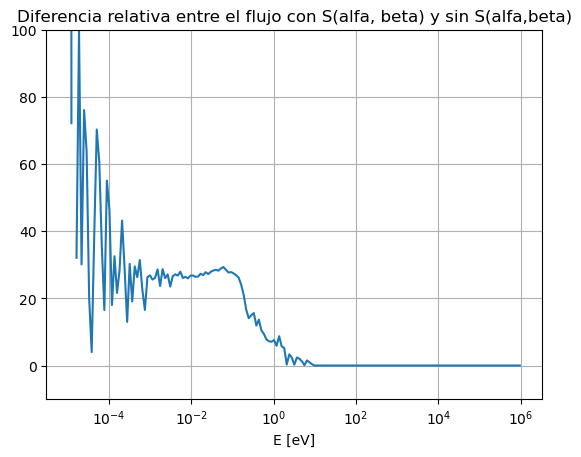

In [29]:
plt.semilogx(E,(abs(data_meanS-data_mean)/data_meanS)*100)
plt.xlabel('E [eV]')
plt.ylabel('')
plt.ylim(-10,100)
plt.title('Diferencia relativa entre el flujo con S(alfa, beta) y sin S(alfa,beta)')
plt.grid()
plt.show()

### Corriente a la salida z=Lz sin S  

In [30]:
leak_salida = sp_1.get_tally(name='leakage_salida')
leak_entrada = sp_1.get_tally(name='leakage_entrada')
leak_2 = sp_1.get_tally(name='leakage_2')
leak_3 = sp_1.get_tally(name='leakage_3')
leak_4 = sp_1.get_tally(name='leakage_4')
leak_5 = sp_1.get_tally(name='leakage_5')
print(abs(leak_salida.mean),abs(leak_entrada.mean),abs(leak_2.mean),abs(leak_3.mean ),abs(leak_4.mean) ,abs(leak_5.mean)) 
print(abs(leak_salida.mean)+abs(leak_entrada.mean)+abs(leak_2.mean)+abs(leak_3.mean) +abs(leak_4.mean) +abs(leak_5.mean))

[[[0.01615182]]] [[[0.71034545]]] [[[0.06857273]]] [[[0.06818818]]] [[[0.06816364]]] [[[0.06863818]]]
[[[1.00006]]]


### Corriente a la salida z=Lz con S  

In [31]:
leak_salida = sp_2.get_tally(name='leakage_salida')
leak_entrada = sp_2.get_tally(name='leakage_entrada')
leak_2 = sp_2.get_tally(name='leakage_2')
leak_3 = sp_2.get_tally(name='leakage_3')
leak_4 = sp_2.get_tally(name='leakage_4')
leak_5 = sp_2.get_tally(name='leakage_5')
print(abs(leak_salida.mean),abs(leak_entrada.mean),abs(leak_2.mean),abs(leak_3.mean ),abs(leak_4.mean) ,abs(leak_5.mean)) 
print(abs(leak_salida.mean)+abs(leak_entrada.mean)+abs(leak_2.mean)+abs(leak_3.mean) +abs(leak_4.mean) +abs(leak_5.mean))

[[[0.01617545]]] [[[0.71054]]] [[[0.06873727]]] [[[0.06835909]]] [[[0.06807727]]] [[[0.06858455]]]
[[[1.00047364]]]
